In [1]:
import dicom
import matplotlib.pyplot as plt

%matplotlib inline

from pathlib import Path
import tensorflow as tf
import numpy as np
from tqdm import tqdm_notebook
import scipy.misc
from skimage import io
import scipy.stats
import seaborn as sns
import skimage.color
from skimage.filters import threshold_otsu
import keras

from matplotlib import animation
from IPython.display import HTML
from PIL import Image
import pandas as pd

Using TensorFlow backend.


In [2]:
dicom_files = [x for x in Path('./torso/rfmri/MR').iterdir() if x.is_file() and not 'ds_store' in str(x).lower()]
dicom_files.sort(key=str)

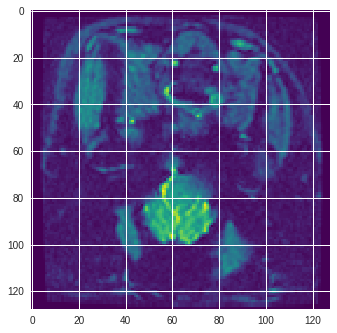

In [3]:
# here's our sample pig in false color image form (viridis cmap)
pig0 = dicom.read_file(str(dicom_files[22]), force=True)
im = pig0.pixel_array
plt.imshow(im, cmap='viridis')

In [4]:
# let's try loading the entire thing to ram
# the big tensor will have dimension [time, depth, height, width]


im = pig0.pixel_array
all_data = np.zeros((120, 47, im.shape[0], im.shape[1]))

for f in tqdm_notebook(dicom_files):
    pigfile = dicom.read_file(str(f), force=True)
    
    try:
    
        time = (pigfile.InstanceNumber - 1) // 47
        depth = pigfile.InStackPositionNumber - 1


        if np.count_nonzero(all_data[time, depth]) > 0:
            print('repeated stack position @ time %d , depth %d' % (time, depth))

        all_data[time, depth, ...] = pigfile.pixel_array
    except:
        print(f)
    
    

In [5]:
assert all_data.shape == (120, 47, 128, 128) # basic sanity check

In [6]:
# extract all slices at t=0 in png to annotate with imagej
slicedir = Path('./seg_slices')
slicedir.mkdir(exist_ok=True)

for i, brain_slice in enumerate(tqdm_notebook(all_data[0])):
    filename = './seg_slices/slice_{}.png'.format(i)
    scipy.misc.toimage(brain_slice).save(filename)
    
    
# then use this thing to segment in 3d http://imagej.net/Trainable_Weka_Segmentation

In [7]:
import scipy.stats

scipy.stats.describe(all_data[0].flat)

DescribeResult(nobs=770048, minmax=(0.0, 5599.0), mean=377.42074000581783, variance=150212.03951245255, skewness=2.1149271851111107, kurtosis=5.985433753819269)

KeyError: 'ffmpeg'

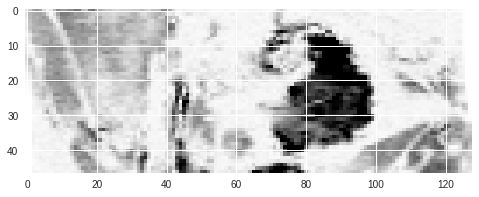

In [8]:
fig, ax = plt.subplots()

im = plt.imshow(all_data[0, :, 12, :], animated=True, interpolation='none')

# animation function. This is called sequentially
def animate(i):
#     im.set_array(all_data[i % 120, 22])  # going in time at middle of head from top
#     im.set_array(all_data[0, i % 47]) # going in from top of head
#     im.set_array(all_data[0, :, :, i % 128]) # going in from cheek
    im.set_array(all_data[i%120, :, :, 70]) # going in time at slice in middle of head from cheek
#     im.set_array(all_data[0, :, i % 128, :]) # going in from snout
    
    return im,

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, interval=100, blit=True)



HTML(anim.to_html5_video())

In [11]:
# gotta transform the segmentation mask into a binary image
color_mask = io.imread('./t0_segment_v1.tif')
binary_mask = np.zeros(color_mask.shape[:-1])


for i, z_slice in enumerate(color_mask):
    gray_slice = skimage.color.rgb2gray(z_slice)
    
    if np.max(gray_slice) == np.min(gray_slice):
        # only one color in this slice, it must be background
        print('no foreground in slice %d' % i)
        binary_slice = np.zeros(gray_slice.shape[:2])
        
    else:
        thresh = threshold_otsu(gray_slice)
        binary_slice = gray_slice <= thresh

    
    binary_mask[i] = binary_slice

io.imsave('./t0_bin_segment_v1.tif', binary_mask)

no foreground in slice 0
no foreground in slice 1
no foreground in slice 2
no foreground in slice 3
no foreground in slice 4
no foreground in slice 5
no foreground in slice 45


In [6]:
# use annotation to select pixels from volume
binary_mask = io.imread('./t0_bin_segment_v1.tif')

indices = np.nonzero(binary_mask)


df_index = pd.MultiIndex.from_tuples(list(zip(*indices)), names=['depth', 'row', 'col'])
series_df = pd.Series(index=df_index, dtype=object)


for i, triple in tqdm_notebook(enumerate(zip(*indices)), total=len(indices[0])):
    d, r, c = triple
    trace = all_data[:, d, r, c]
    
    series_df.loc[triple] = trace

In [22]:
def model():
    from keras.layers.convolutional import Conv1D, UpSampling1D
    from keras.layers.pooling import MaxPooling1D
    from keras.layers.core import Dense, Activation
    from keras.layers.normalization import BatchNormalization
    
    model = keras.models.Sequential()
    
    # padding is unspecified in paper, but maybe should be causal
    
    
    # encoder
    model.add(Conv1D(32, 3, padding='causal', input_shape=[120, 1]))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv1D(64, 3, padding='causal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D())
    
    model.add(Conv1D(128, 3, padding='causal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D())
    
    model.add(Conv1D(256, 3, padding='causal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D())
    
    # hidden state bottleneck - one interesting thing is that the size is the same as the input
    # I think the hope is that this recovers the driving stimulus
    
    model.add(Dense(120))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    # decoder
    model.add(Conv1D(256, 3, padding='causal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling1D())
    
    model.add(Conv1D(128, 3, padding='causal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling1D())
    
    model.add(Conv1D(64, 3, padding='causal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling1D())
    
    model.add(Conv1D(32, 3, padding='causal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv1D(1, 1, padding='causal'))
    model.add(Activation('linear'))
    
    # section 2.1 mentions a special regularization, but I don't think that is going to work
    # the feature map in the compressed representation and the output will not be timeshuffled if we use causal conv
    
    return model


m = model()

from keras.callbacks import LearningRateScheduler
import math

# learning rate schedule
# def step_decay(epoch):
# 	initial_lrate = 0.1
# 	lrate = initial_lrate * (.8 ** (epoch/10))
# 	return lrate

# learning rate schedule
def step_decay(epoch):
	initial_lrate = 0.01
	drop = 0.5
	epochs_drop = 10.0
	lrate = initial_lrate * drop**(np.floor((1+epoch)/epochs_drop))
	return lrate

lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]


# no optimizer specified, but let's use rmsprop
from keras import optimizers

opt = optimizers.RMSprop(lr=0.01)
m.compile(optimizer=opt, loss='mse')




    

In [8]:
data_block = np.vstack(series_df.values)[..., np.newaxis]

# extract train / val sets

shuffled_data = np.copy(data_block)
np.random.shuffle(shuffled_data)

validation_set = shuffled_data[:1000]  #hold back 1000 for validation
training_set = shuffled_data[1000:]   #train on 12550 samples

In [9]:
print(validation_set.shape)
print(data_block.shape)

(1000, 120, 1)
(13550, 120, 1)


In [23]:
print('are you sure you want to start training')
are_you_sure = input()

if are_you_sure.lower() != 'yes':
    raise Exception()

m.fit(training_set, training_set, epochs=50, batch_size=32, callbacks=callbacks_list)
m.save('e7_model.h5')

are you sure you want to start training
yes
Epoch 1/50
12550/12550 [==============================] - 23s - loss: 2531477.5859    
Epoch 2/50
12550/12550 [==============================] - 22s - loss: 366999.0985    
Epoch 3/50
12550/12550 [==============================] - 22s - loss: 17341.0409    
Epoch 4/50
12550/12550 [==============================] - 22s - loss: 14857.2258    
Epoch 5/50
12550/12550 [==============================] - 23s - loss: 13283.6973    
Epoch 6/50
12550/12550 [==============================] - 23s - loss: 13151.3433    
Epoch 7/50
12550/12550 [==============================] - 22s - loss: 11657.7055    
Epoch 8/50
12550/12550 [==============================] - 22s - loss: 11505.8317    
Epoch 9/50
12550/12550 [==============================] - 22s - loss: 11700.3394    
Epoch 10/50
12550/12550 [==============================] - 22s - loss: 10813.1389    
Epoch 11/50
12550/12550 [==============================] - 22s - loss: 10036.0992    
Epoch 12/50
1255

In [24]:
m.evaluate(validation_set, validation_set)

# hot dog, val performance is better than train performance

 992/1000 [============================>.] - ETA: 0s

4831.4399277343746

In [5]:
from keras import backend as K
from keras.models import load_model
m = load_model('e7_model.h5')
layer = m.get_layer(index=1)

sample_1 = data_block[np.newaxis, 1000]
recon_1 = m.predict(sample_1)

plt.figure(figsize=(20, 10))
plt.subplot(611)
plt.plot(np.squeeze(sample_1))
plt.plot(np.squeeze(recon_1))

weight_1 = layer.get_weights()[0][0][0]
weight_2 = layer.get_weights()[0][1][0]
weight_3 = layer.get_weights()[0][2][0]

plt.figure(figsize=(20, 10))
plt.subplot(611)
plt.plot([weight_1[0], weight_2[0], weight_3[0]], c='r')
plt.plot([weight_1[1], weight_2[1], weight_3[1]], c='g')
plt.plot([weight_1[2], weight_2[2], weight_3[2]], c='b')
plt.plot([weight_1[3], weight_2[3], weight_3[3]], c='y')

layer2 = m.get_layer(index=4)

weight_1 = layer2.get_weights()[0][0][0]
weight_2 = layer2.get_weights()[0][1][0]
weight_3 = layer2.get_weights()[0][2][0]

plt.figure(figsize=(20, 10))
plt.subplot(611)
plt.plot([weight_1[0], weight_2[0], weight_3[0]], c='r')
plt.plot([weight_1[1], weight_2[1], weight_3[1]], c='g')
plt.plot([weight_1[2], weight_2[2], weight_3[2]], c='b')
plt.plot([weight_1[3], weight_2[3], weight_3[3]], c='y')


remember_output = layer2.output
output_1 = m.predict(sample_1)
print(remember_output)

get_4th_layer_output = K.function([m.get_layer(index=0).input, K.learning_phase()],
                                  [m.get_layer(index=1).output])
layer_output = get_4th_layer_output([sample_1, 0])[0]

plt.figure(figsize=(20, 10))
plt.subplot(611)
plt.plot(layer_output[0,:,0], c='r')
plt.plot(layer_output[0,:,1], c='g')
plt.plot(layer_output[0,:,2], c='b')
plt.plot(layer_output[0,:,3], c='y')


ImportError: `load_model` requires h5py.

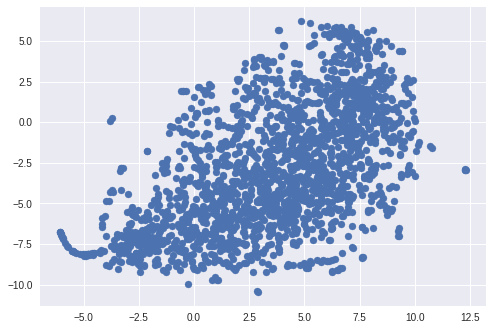

In [33]:
from sklearn import manifold
from time import time

# quick and dirty embedding visualization on val set
sub_block = data_block[:2000]


embedding_model = keras.models.Model(inputs=m.input,
                                 outputs=m.layers[17].output)

embeddings = embedding_model.predict(sub_block)

tsne = manifold.TSNE(n_components=2, init='random', random_state=0, n_iter=5000, perplexity=100)
t0 = time()
squished_embeddings = np.reshape(embeddings, (embeddings.shape[0], -1))
X_tsne = tsne.fit_transform(squished_embeddings)


plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

# what the fuck.....

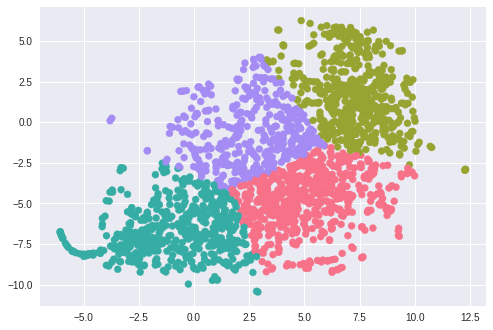

In [35]:
# color (kmeans) and label
from sklearn.cluster import KMeans
qualitative_clusters = 4

my_kmeans = KMeans(n_clusters=qualitative_clusters, n_init=10)

rgbs = [np.array(c) for c in sns.color_palette("husl", qualitative_clusters)]

my_kmeans.fit(X_tsne)
labels = my_kmeans.labels_

colors = [rgbs[i] for i in labels]

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors)

1000

In [50]:
blah = pd.DataFrame({'color': colors, 'label': labels})
blah.index = df_index

ValueError: Length mismatch: Expected axis has 1000 elements, new values have 13550 elements

In [23]:
# weird_x_tsne = X_tsne
# actually I can't undo the permutation so no point here

In [ ]:
# coloring experiments